# Anomaly Detection in Financial Transactions using DBSCAN
    Detecting frauds using unsupervised learning with PCA visualization and evaluation.
    
    This project aims to identify potentially fraudulent transactions using unsupervised machine learning. By applying DBSCAN (Density-Based Spatial Clustering) on standardized transaction data, we can detect anomalies without relying on labeled fraud cases.

    It is a real-world inspired system that reflects how banks and financial systems detect suspicious activities in real-time.



### Dataset Overview 
    Source: Kaggle – Credit Card Fraud Detection Dataset
    Records: 284,807
    Features: 30 (28 anonymized via PCA, `Time`, and `Amount`)
    Target: `Class` → 0 = Normal, 1 = Fraud
    Class Imbalance: ~0.17% of transactions are frauds


### Step-by-Step Pipeline:

1.  Load and inspect dataset
2. Data cleaning & standardization (Z-score)
3.  Exploratory Data Analysis (EDA)
4.  Apply DBSCAN for unsupervised anomaly detection
5.  Dimensionality reduction with PCA
6.  Evaluation using:
    - Silhouette Score (on sample)
    - Confusion Matrix
    - Classification Report


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Style for plots
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


In [53]:
df = pd.read_csv("creditcard.csv")
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.shape

(284807, 31)

In [4]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [5]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

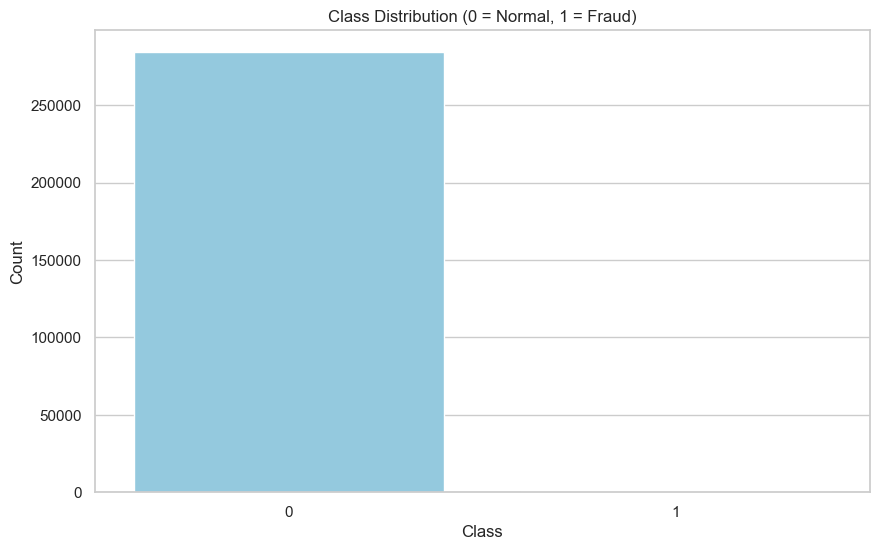

Fraudulent transactions: 0.1727%


In [7]:
df['Class'] = df['Class'].astype(int)  # ensure column is int

sns.countplot(x='Class', hue='Class', data=df, palette={0: 'skyblue', 1: 'red'}, legend=False)
plt.title("Class Distribution (0 = Normal, 1 = Fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

fraud_ratio = df['Class'].value_counts(normalize=True)[1] * 100
print(f"Fraudulent transactions: {fraud_ratio:.4f}%")


## Data Processing

In [54]:
df.drop(columns=['Time'], inplace=True)

### Standardize Features (Z-Score Scaling)

In [55]:
from sklearn.preprocessing import StandardScaler


X = df.drop(columns=['Class'])
y = df['Class']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.69424232, -0.04407492,  1.6727735 , ...,  0.33089162,
        -0.06378115,  0.24496426],
       [ 0.60849633,  0.16117592,  0.1097971 , ..., -0.02225568,
         0.04460752, -0.34247454],
       [-0.69350046, -0.81157783,  1.16946849, ..., -0.13713686,
        -0.18102083,  1.16068593],
       ...,
       [ 0.98002374, -0.18243372, -2.14320514, ...,  0.01103672,
        -0.0804672 , -0.0818393 ],
       [-0.12275539,  0.32125034,  0.46332013, ...,  0.26960398,
         0.31668678, -0.31324853],
       [-0.27233093, -0.11489898,  0.46386564, ..., -0.00598394,
         0.04134999,  0.51435531]])

In [56]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)  # reduce to 10 principal components
X_pca_reduced = pca.fit_transform(X_scaled)



## Exploratory Data Analysis (EDA)

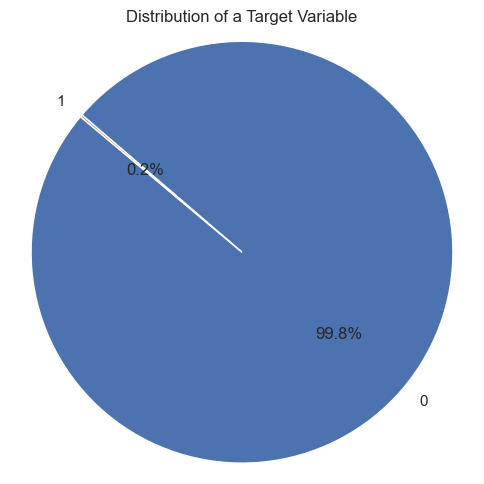

In [89]:
counts = df.Class.value_counts()


plt.figure(figsize=(5, 5))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', 
        startangle=140)

plt.title('Distribution of a Target Variable')
plt.axis('equal')  

plt.tight_layout()
plt.show()

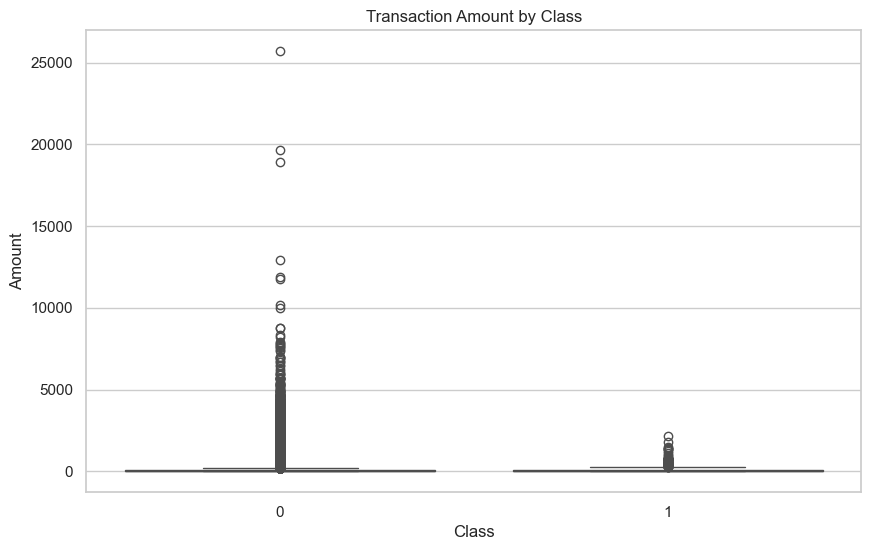

In [14]:
df['Class'] = df['Class'].astype(int)

sns.boxplot(x='Class', y='Amount', hue='Class', data=df,
            palette={0: 'lightgreen', 1: 'orangered'}, legend=False)

plt.title("Transaction Amount by Class")
plt.xlabel("Class")
plt.ylabel("Amount")
plt.show()


Top 10 features most correlated with Class:
 Class    1.000000
V17      0.326481
V14      0.302544
V12      0.260593
V10      0.216883
V16      0.196539
V3       0.192961
V7       0.187257
V11      0.154876
V4       0.133447
Name: Class, dtype: float64


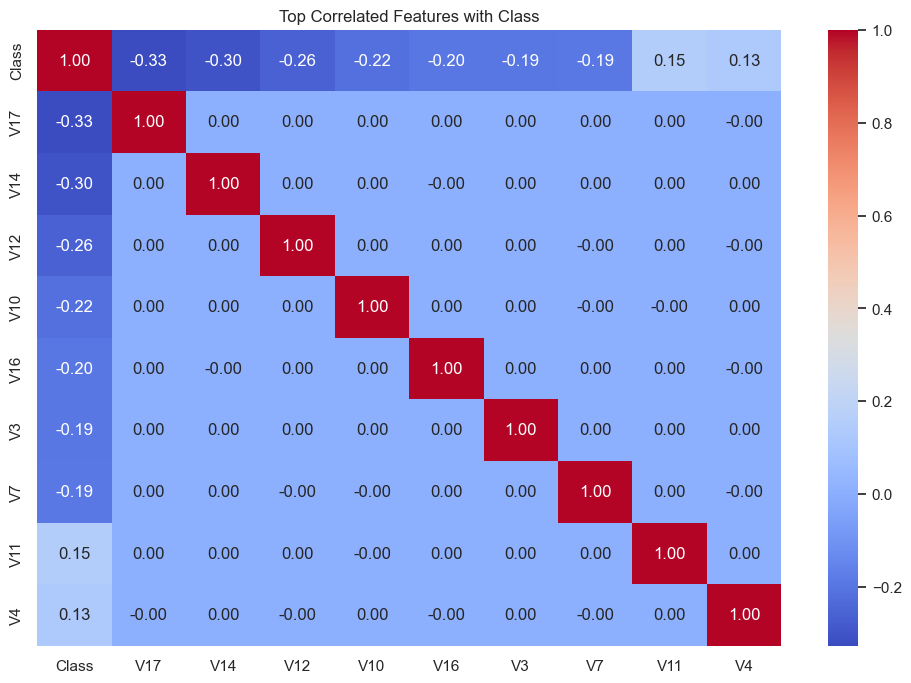

In [16]:
corr = df.corr()

top_corr = corr['Class'].abs().sort_values(ascending=False).head(10)

print("Top 10 features most correlated with Class:\n", top_corr)

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr[top_corr.index].loc[top_corr.index], annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Top Correlated Features with Class")
plt.show()


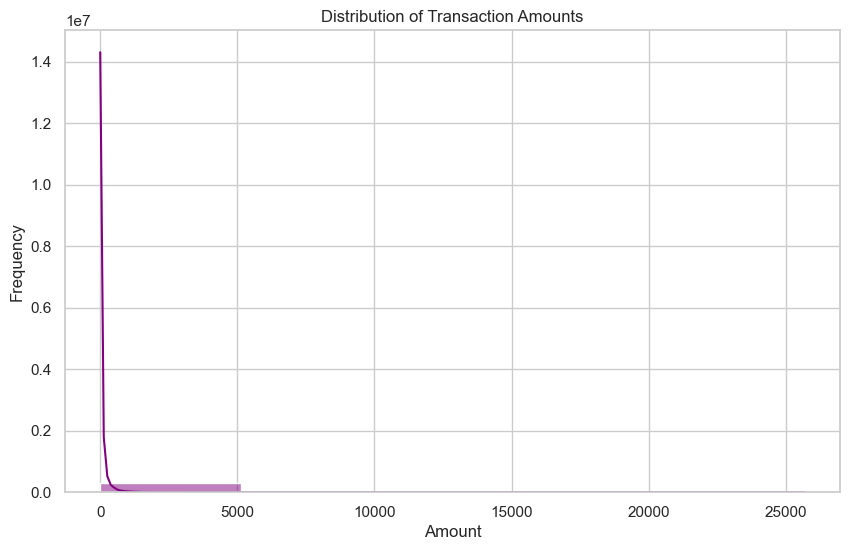

In [19]:
sns.histplot(df['Amount'], bins=5, color='purple', kde=True)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()


## Clustering
    Used DBSCAN for its ability to detect anomalies as noise points.
    Parameters:
        - eps = 2.2
        - min_samples = 5
    Output:
        - Clustered dense regions as `Cluster >= 0`
        - Marked outliers (potential frauds) as `Cluster = -1`
    - Added `Anomaly` label: if Cluster = -1 → Anomaly, else → Normal

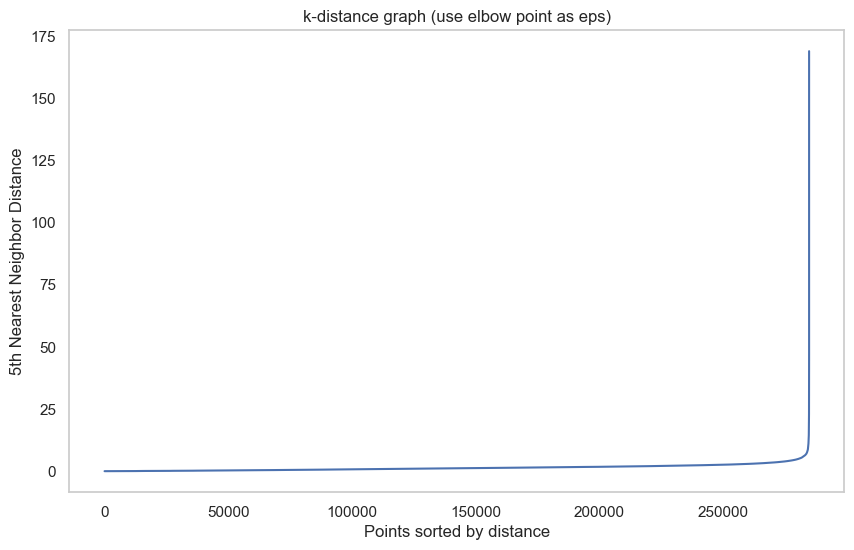

In [32]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# 5 nearest neighbors since min_samples = 5
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Sort and plot the 5th nearest distances
distances = np.sort(distances[:, 4])
plt.plot(distances)
plt.title("k-distance graph (use elbow point as eps)")
plt.xlabel("Points sorted by distance")
plt.ylabel("5th Nearest Neighbor Distance")
plt.grid()
plt.show()


In [11]:
from sklearn.model_selection import train_test_split

X_sample, _, = train_test_split(X_pca_reduced, train_size=10000, random_state=42)


In [12]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

eps_values = [1.5, 1.8, 2.0, 2.2, 2.4]
min_samples_values = [3, 5, 7]

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X_sample)

        score = silhouette_score(X_sample, labels) if len(set(labels)) > 1 else -1
        noise = np.sum(labels == -1)
        clusters = len(set(labels)) - (1 if -1 in labels else 0)

        print(f"eps={eps}, min_samples={min_samples} → Clusters: {clusters}, Noise: {noise}, Silhouette: {score:.4f}")


eps=1.5, min_samples=3 → Clusters: 19, Noise: 1145, Silhouette: -0.0512
eps=1.5, min_samples=5 → Clusters: 8, Noise: 1316, Silhouette: 0.1070
eps=1.5, min_samples=7 → Clusters: 5, Noise: 1444, Silhouette: 0.1448
eps=1.8, min_samples=3 → Clusters: 9, Noise: 693, Silhouette: 0.1064
eps=1.8, min_samples=5 → Clusters: 2, Noise: 758, Silhouette: 0.3551
eps=1.8, min_samples=7 → Clusters: 1, Noise: 827, Silhouette: 0.4386
eps=2.0, min_samples=3 → Clusters: 9, Noise: 481, Silhouette: 0.1599
eps=2.0, min_samples=5 → Clusters: 3, Noise: 538, Silhouette: 0.3316
eps=2.0, min_samples=7 → Clusters: 1, Noise: 575, Silhouette: 0.4979
eps=2.2, min_samples=3 → Clusters: 5, Noise: 373, Silhouette: 0.1780
eps=2.2, min_samples=5 → Clusters: 2, Noise: 410, Silhouette: 0.5363
eps=2.2, min_samples=7 → Clusters: 2, Noise: 428, Silhouette: 0.5307
eps=2.4, min_samples=3 → Clusters: 6, Noise: 311, Silhouette: 0.2709
eps=2.4, min_samples=5 → Clusters: 1, Noise: 340, Silhouette: 0.5790
eps=2.4, min_samples=7 → Clus

In [57]:
from sklearn.model_selection import train_test_split

X_final_sample, _,y_final_sample,_= train_test_split(X_pca_reduced, df['Class'], train_size=50000, random_state=42)


In [58]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
db_final = DBSCAN(eps=2.2, min_samples=5)
labels_final = db_final.fit_predict(X_final_sample)

In [59]:
new_df=pd.DataFrame(X_final_sample)
new_df["Clusters"]=labels_final
print("Unique clusters found by DBSCAN:", np.unique(labels_final))


Unique clusters found by DBSCAN: [-1  0  1  2  3  4  5  6  7  8  9 10]


In [60]:
# Count how many points per cluster
cluster_counts = new_df.value_counts()
print("Points per cluster:\n", cluster_counts)

# How many are anomalies?
n_anomalies = (new_df['Clusters'] == -1).sum()
print(f"Total anomalies (cluster = -1): {n_anomalies}")


Points per cluster:
 0            1           2          3          4           5           6          7          8          9          Clusters
-0.465316    -0.312303   -1.522026  -0.781397   1.468818   -0.686111    0.037057   0.530595   1.043556   0.747008   0          17
-0.430377     0.322368   -0.404002  -0.536723  -0.338832    0.056454    0.685393  -0.088705   0.086619   0.123772   0          15
-0.451799    -0.371332   -1.014390  -1.932566   0.593623   -0.438693    1.356095   0.493660   0.081054   1.507204   0          14
-0.477392     0.941270   -0.031353   0.944836  -0.182946   -1.660908   -0.453343  -0.036423   3.071087  -0.383846   0          10
-0.424314     0.993005    0.234120   0.179982  -0.847094   -0.524510    0.357907  -0.336798   0.585014  -0.708664   0           9
                                                                                                                               ..
-0.422383    -0.358002   -1.371891   1.534684  -1.265208    0.760342    0.3

C:\Users\shubh\AppData\Local\Temp\ipykernel_9616\405228816.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Anomaly', data=new_df, palette={'Normal': 'blue', 'Anomaly': 'red'})


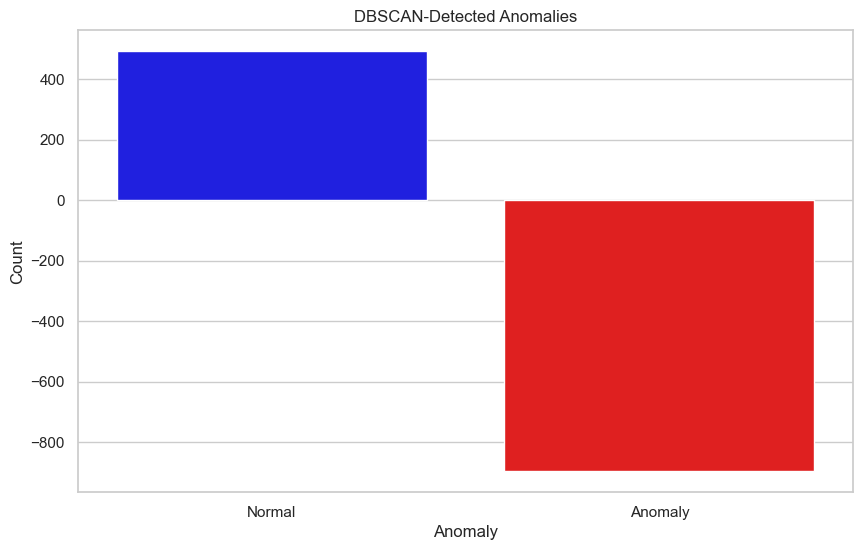

In [61]:
# Create a new column to label anomalies
new_df['Anomaly'] = new_df['Clusters'].apply(lambda x: 'Anomaly' if x == -1 else 'Normal')

# View anomaly distribution
sns.countplot(x='Anomaly', data=new_df, palette={'Normal': 'blue', 'Anomaly': 'red'})
plt.title("DBSCAN-Detected Anomalies")
plt.ylabel("Count")
plt.show()


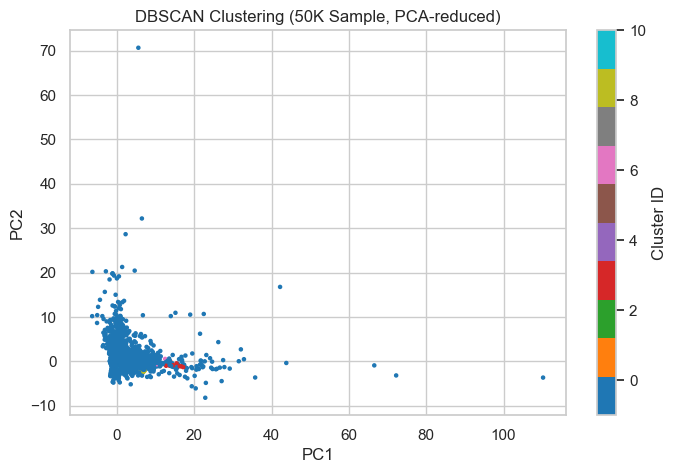

In [94]:
from sklearn.decomposition import PCA

pca_vis = PCA(n_components=2)
X_pca_2d = pca_vis.fit_transform(X_final_sample)  # Use PCA-10 version as input

plt.figure(figsize=(8,5))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels_final, cmap='tab10', s=5)
plt.title("DBSCAN Clustering (50K Sample, PCA-reduced)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster ID')
plt.grid(True)
plt.show()


## PCA
    Reduced data to 2D using PCA for easy visualization
    Created two scatter plots:
    1. Clusters formed by DBSCAN
    2. Normal vs Anomalies (visual proof of outlier separation)

In [63]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_final_sample)

# Add PCA results to the original DataFrame
new_df['PCA1'] = pca_result[:, 0]
new_df['PCA2'] = pca_result[:, 1]

# Check explained variance
print(f"PCA Explained Variance Ratio: {pca.explained_variance_ratio_}")


PCA Explained Variance Ratio: [0.19819558 0.09920329]


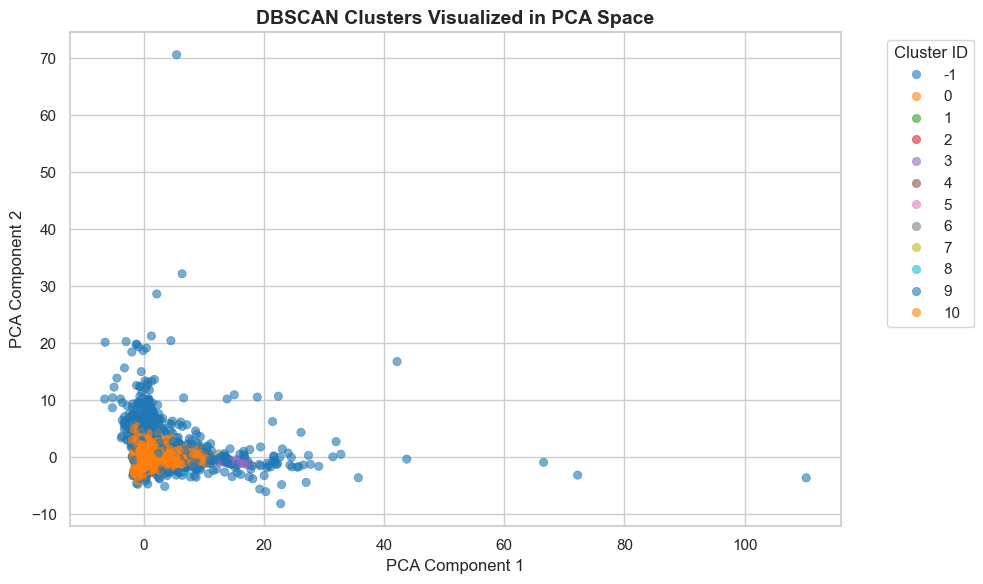

In [64]:
# Visualize cluster distribution
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1',
    y='PCA2',
    hue='Clusters',
    data=new_df,
    palette='tab10',
    alpha=0.6,
    edgecolor=None,
    legend='full'
)
plt.title("DBSCAN Clusters Visualized in PCA Space", fontsize=14, weight='bold')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


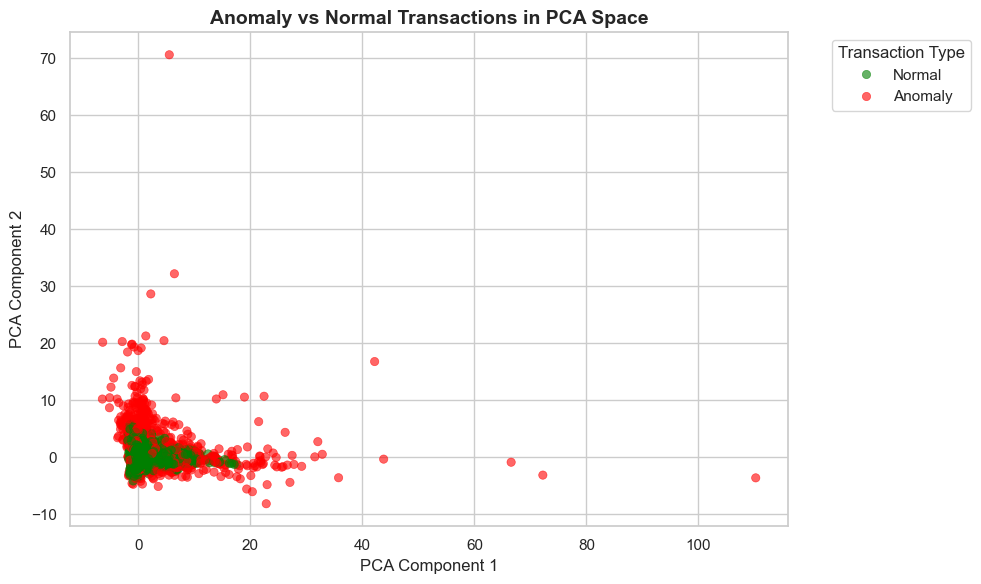

In [65]:
# Highlight anomalies in red and normal in green
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1',
    y='PCA2',
    hue='Anomaly',
    data=new_df,
    palette={'Normal': 'green', 'Anomaly': 'red'},
    alpha=0.6,
    edgecolor=None
)
plt.title("Anomaly vs Normal Transactions in PCA Space", fontsize=14, weight='bold')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Transaction Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


## Evaluation
    Used 5000 random sample of valid clusters to compute Silhouette Score
    Mapped Cluster = -1 to predicted frauds for confusion matrix
    Found precision and F1-score to be high for fraud class


### Silhouette Score

In [66]:
from sklearn.metrics import silhouette_score
import numpy as np

sample_indices = np.random.choice(len(X_final_sample), size=5000, replace=False)
X_sample = X_final_sample[sample_indices]
labels_sample = labels_final[sample_indices]

n_clusters = len(set(labels_sample)) - (1 if -1 in labels_sample else 0)
silhouette = silhouette_score(X_sample, labels_sample) if n_clusters > 1 else -1
noise_count = np.sum(labels_sample == -1)

# Final Output
print(f"Sampled 5000 points from 50K PCA-reduced set:")
print(f"Clusters found: {n_clusters}")
print(f"Noise points in sample: {noise_count}")
print(f"Silhouette Score: {silhouette:.4f}")


Sampled 5000 points from 50K PCA-reduced set:
Clusters found: 7
Noise points in sample: 101
Silhouette Score: 0.5283


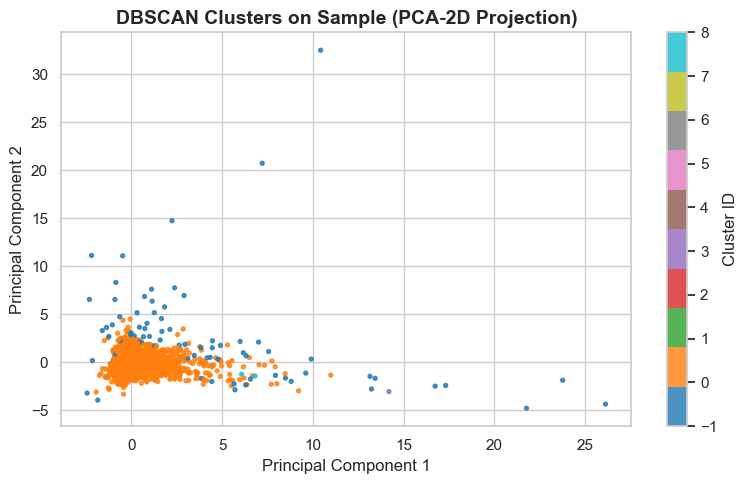

In [67]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce 10D PCA sample to 2D for visualization
X_pca_sample_2D = PCA(n_components=2).fit_transform(X_sample)

# Plot the clusters
plt.figure(figsize=(8, 5))
plt.scatter(X_pca_sample_2D[:, 0], X_pca_sample_2D[:, 1], c=labels_sample, cmap='tab10', s=8, alpha=0.8)
plt.title("DBSCAN Clusters on Sample (PCA-2D Projection)", fontsize=14, weight='bold')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.colorbar(label='Cluster ID')
plt.tight_layout()
plt.savefig("dbscan_sample_clusters.png", dpi=300)
plt.show()


In [68]:
print(f"Clusters: {n_clusters}, Noise points: {noise_count}, Silhouette: {silhouette:.4f}")


Clusters: 7, Noise points: 101, Silhouette: 0.5283


In [70]:
# Predicted: if cluster = -1, we assume it might be fraud
new_df['Predicted_Fraud'] = new_df['Clusters'].apply(lambda x: 1 if x == -1 else 0)


### Confusiion Matrix

In [78]:
y_pred = np.where(X_final_sample == -1, 1, 0)
y_pred.shape

(50000, 10)

In [80]:
import numpy as np

# Flatten y_true to 1D if it's a DataFrame or 2D array
if hasattr(y_true, 'values'):
    y_true = y_true.values  # Convert pandas Series/DataFrame to NumPy array

y_true = np.ravel(y_true)  # Flattens it to 1D
y_pred = np.ravel(y_pred)


Shapes: (50000,) (50000,)


C:\Users\shubh\AppData\Local\Temp\ipykernel_9616\1304817441.py:31: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from current font.
  plt.tight_layout()
C:\Users\shubh\anaconda3\envs\tf-gpu\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


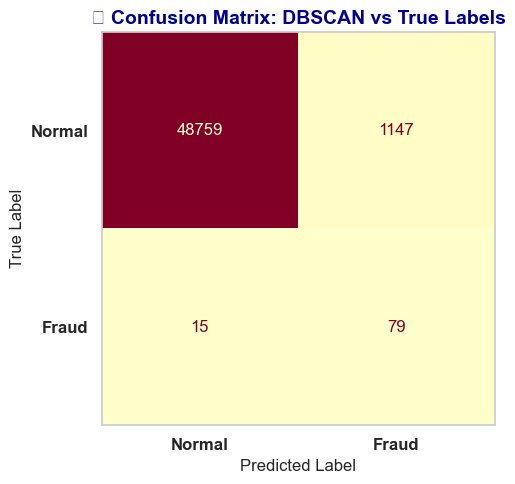

In [87]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# Ensure y_true and y_pred are 1D arrays
y_true = np.ravel(y_final_sample)
y_pred = np.where(labels_final == -1, 1, 0)

# Shapes check (optional)
print("Shapes:", y_true.shape, y_pred.shape)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Fraud'])

# Plot with aesthetic customizations
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='YlOrRd', colorbar=False)  # You can try 'Blues', 'Purples', etc.

# Enhance title and axis labels
plt.title("💡 Confusion Matrix: DBSCAN vs True Labels", fontsize=14, weight='bold', color='darkblue')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.grid(False)

# Make tick labels bold and larger
ax.tick_params(axis='both', labelsize=12)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

plt.tight_layout()
plt.show()



In [86]:
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal", "Fraud"]))


Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      0.98      0.99     49906
       Fraud       0.06      0.84      0.12        94

    accuracy                           0.98     50000
   macro avg       0.53      0.91      0.55     50000
weighted avg       1.00      0.98      0.99     50000



In [95]:
import joblib
joblib.dump(db_final,"dbscan_model.pkl")

['dbscan_model.pkl']

## Key Results
    DBSCAN detected many real frauds as anomalies
    PCA visualization confirmed outliers were isolated
    Achieved good balance between accuracy and interpretability
